## Preparing a dataset for supervised instruction fine-tuning

In [ ]:
# Downloading the dataset
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(text_data)
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

file_path = 'instruction-data.json'
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
data[50]

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'"}

In [3]:
data[999]

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'."}

In [4]:
# Implementing prompt formatting function to convert dataset entries into Alpaca-style input formats

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""
    )

    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [7]:
# Splitting dataset into train, validation, and test sets

train_portion = int(len(data) * 0.85) # 85% for training
test_portion = int(len(data) * 0.10)   # 10% for testing
val_portion = len(data) - train_portion - test_portion # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

In [8]:
# InstructionDataset class which applies formating the input and pretokenize

import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    
    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [10]:
# A custom collate function that pads the training examples in each batch to the same length while allowing different batches to have different lengths

def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item +=[pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1]) # Removes extra padding token added earlier
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)

    return inputs_tensor

In [11]:
# Test custom_collate_draft_1
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = [inputs_1, inputs_2, inputs_3]
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [12]:
# Updated custom collate function to generate target token ids (Shifting one position to the right and appending an end-of-text token)
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Removes extra padding token added earlier
        targets = torch.tensor(padded[1:])  # Shifted version of inputs
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [13]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [14]:
# Implementing a comprehensive custom batch collate function

def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Removes extra padding token added earlier
        targets = torch.tensor(padded[1:])  # Shifted version of inputs

        # Replace all padding tokens except the first one in targets by ignore_index. This is to ensure that the model does not learn from padding tokens.
        mask = (targets == pad_token_id)
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None: # Optionally truncates to the maximum sequence length
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


## Creating data loaders for an instruction dataset

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [17]:
from functools import partial

# Creating a partial function for the custom collate function with device and allowed_max_length parameter
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [18]:
# Creating data loaders

from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    collate_fn=customized_collate_fn
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    collate_fn=customized_collate_fn
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    collate_fn=customized_collate_fn
)

In [19]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

## Loading a pretrained LLM

In [20]:
# Loading pretrained model
CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {
        "emb_dim": 768,
        "n_layers": 12,
        "n_heads": 12
    },
    "gpt2-medium (355M)": {
        "emb_dim": 1024,
        "n_layers": 24,
        "n_heads": 16
    },
    "gpt2-large (774M)": {
        "emb_dim": 1280,
        "n_layers": 36,
        "n_heads": 20
    },
    "gpt2-xl (1558M)": {
        "emb_dim": 1600,
        "n_layers": 48,
        "n_heads": 25
    }
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [21]:
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 1024,
 'n_layers': 24,
 'n_heads': 16}

In [22]:
from gpt_download import download_and_load_gpt2
from utils.gpt_model import GPTModel
from utils.weight_loader import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

2025-08-24 13:13:12.643643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model_size

'355M'

In [24]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 45.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.62MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 93.2kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [00:27<00:00, 51.3MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 3.20MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.33MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.39MiB/s]


In [25]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [26]:
# Check pre-trained model's performance on instruction following task

torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [27]:
from utils.text_generation import generate_text, text_to_token_ids, token_ids_to_text
token_ids = generate_text(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)
generated_text = token_ids_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [28]:
# Extract model response text
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Fine-tuning the LLM on instruction data

In [29]:
from utils.gpt_training import train_model_simple, calc_loss_loader

# Calculating initial loss for training and validation sets
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)

Training Loss: 3.825910949707031
Validation Loss: 3.7619351863861086


In [30]:
# Instruction fine-tuning the pretrained LLM

import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.01)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Ep 1, (Step 000000): Train Loss: 2.637, Val Loss: 2.626
Ep 1, (Step 000005): Train Loss: 1.174, Val Loss: 1.103
Ep 1, (Step 000010): Train Loss: 0.872, Val Loss: 0.944
Ep 1, (Step 000015): Train Loss: 0.857, Val Loss: 0.906
Ep 1, (Step 000020): Train Loss: 0.776, Val Loss: 0.881
Ep 1, (Step 000025): Train Loss: 0.754, Val Loss: 0.859
Ep 1, (Step 000030): Train Loss: 0.800, Val Loss: 0.836
Ep 1, (Step 000035): Train Loss: 0.714, Val Loss: 0.809
Ep 1, (Step 000040): Train Loss: 0.672, Val Loss: 0.806
Ep 1, (Step 000045): Train Loss: 0.633, Val Loss: 0.789
Ep 1, (Step 000050): Train Loss: 0.663, Val Loss: 0.782
Ep 1, (Step 000055): Train Loss: 0.760, Val Loss: 0.763
Ep 1, (Step 000060): Train Loss: 0.719, Val Loss: 0.743
Ep 1, (Step 000065): Train Loss: 0.653, Val Loss: 0.735
Ep 1, (Step 000070): Train Loss: 0.536, Val Loss: 0.732
Ep 1, (Step 000075): Train Loss: 0.568, Val Loss: 0.738
Ep 1, (Step 000080): Train Loss: 0.603, Val Loss: 0.733
Ep 1, (Step 000085): Train Loss: 0.515, Val Loss

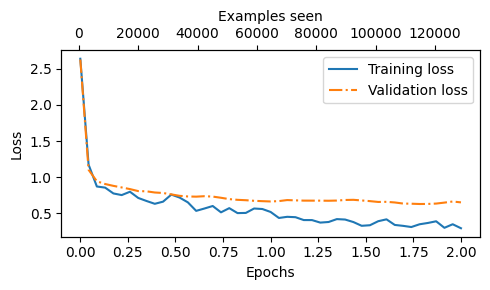

In [31]:
# Plotting losses
from utils.plots_helper import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Extracting and saving responses

In [34]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate_text(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\n Correct response:\n>> {entry['output']}")
    print(f"\n Model response:\n>> {response_text}")
    print("-" * 20)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

 Correct response:
>> The car is as fast as lightning.

 Model response:
>> The car is as fast as a bullet.
--------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

 Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

 Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
--------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

 Correct response:
>> Jane Austen.

 Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.
-----

In [35]:
# generating test set responses
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate_text(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    test_data[i]["model_response"] = response_text

    with open("instruction-data-with-response.json", "w") as file:
        json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [07:49<00:00,  4.26s/it]


## Evaluating the fine-tuned LLM

In [ ]:
# Querying a self-hosted Ollama model

import urllib.request

def query_ollama_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
    ):
    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""

    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [ ]:
judge_model = "llama3"
result = query_ollama_model("What is the capital of Germany?", model=judge_model, url="http://localhost:11434/api/chat")
print(result)

The capital of Germany is Berlin.


In [ ]:
# Rating a few responses from our fine-tuned model using llama3 as evaluator (LLM as judge)

for entry in test_data[:3]:
    prompt = (
        f"Please rate the response of a language model to the following "
        f"instruction on a scale from 1 to 10, where 1 is very bad and 10 is "
        f"excellent. The rating should be based on how well the response "
        f"addresses the instruction and input, as well as its clarity and "
        f"coherence.\n\n"
        f"Input: {format_input(entry)}\n\n"
        f"Correct Response: {entry['output']}\n\n"
        f"Model Response: {entry['model_response']}\n\n"
        f"Rating:"
    )
    rating = query_ollama_model(prompt, model=judge_model, url="http://localhost:11434/api/chat")

    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry['model_response'])
    print("\nRating:")
    print(">>", rating)
    print("-" * 20)


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Rating:
>> I would rate the model's response an 8 out of 10. Here's why:

* The model correctly understood the instruction to rewrite the sentence using a simile.
* The response uses a simile ("as fast as") and compares the car's speed to something else (a bullet).
* However, while "as fast as a bullet" is a common idiomatic expression, it may not be the most creative or unexpected comparison, which is what a simile is meant to provide. A more unusual comparison, like "The car is as fast as lightning," would have been more impressive.

Overall, the model's response is good but not outstanding. It demonstrates an understanding of the instruction and provides a reasonable comparison, but it could be improved with more creative and unexpected language.
--------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model respons

In [44]:
# Evaluating the instruction fine-tuning of our model
def generate_model_scores(json_data, json_key, judge_model="llama3", url="http://localhost:11434/api/chat"):
    scores = []
    for entry in tqdm(json_data, total=len(json_data)):
        prompt = (
            f"Please rate the response of a language model to the following "
            f"instruction on a scale from 1 to 10, where 1 is very bad and 10 is "
            f"excellent. The rating should be based on how well the response "
            f"addresses the instruction and input, as well as its clarity and "
            f"coherence.\n\n"
            f"Input: {format_input(entry)}\n\n"
            f"Correct Response: {entry['output']}\n\n"
            f"Model Response: {entry[json_key]}\n\n"
            f"Respond with the integer rating only."
        )
        rating = query_ollama_model(prompt, model=judge_model, url=url)
        try:
            score = int(rating.strip().split()[0])
            scores.append(score)
        except ValueError:
            print(f"Could not convert rating to int: {rating}")

    return scores

In [ ]:
scores = generate_model_scores(test_data, json_key="model_response", judge_model=judge_model, url="http://localhost:11434/api/chat")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores):.2f}")

100%|██████████| 110/110 [05:11<00:00,  2.83s/it]

Number of scores: 110 of 110
Average score: 5.31


The above evaluation shows that our fine-tuned model achieves an average score of 5.31 out of 10 at this moment. We can try different training configuration to achieve a better score.